In [2]:
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import pandas as pd
import torch
import copy
from tqdm import tqdm
from metrics import evaluation_metrics

from slim import SLIMDataModule
import torch.nn as nn

# Instantiate the DataModule

In [3]:
import matplotlib.pyplot as plt

data_module = SLIMDataModule(data_dir="./data", batch_size=1)
train_dataloader = data_module.train_dataloader()
# Get first batch
batch = next(iter(train_dataloader))
# Visualise the images

Lol


In [4]:
batch[0][0].shape

torch.Size([112, 112])

In [5]:
def symmetric_normalize(A_tilde):
    """
    Performs symmetric normalization of A_tilde (Adj. matrix with self loops):
      A_norm = D^{-1/2} * A_tilde * D^{-1/2}
    Where D_{ii} = sum of row i in A_tilde.

    A_tilde (N, N): Adj. matrix with self loops
    Returns:
      A_norm : (N, N)
    """

    eps = 1e-5
    d = A_tilde.sum(dim=1) + eps
    D_inv = torch.diag(torch.pow(d, -0.5))
    return D_inv @ A_tilde @ D_inv


def batch_normalize(batch):
    batch_n = torch.zeros_like(batch)
    for i, A in enumerate(batch):
        batch_n[i] = symmetric_normalize(A + torch.eye(n=A.shape[0]))
    return batch_n

In [89]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def train_model(
    model,
    train_dataloader,
    val_dataloader,
    num_epochs=100,
    lr=0.01,
    validate_every=1,
    patience=10,
    criterion=None,
    **kwargs,
):
    """
    Train the model, validate every 'validate_every' epochs, and pick the
    checkpoint with best validation accuracy.

    Parameters:
    -----------
    model : torch.nn.Module
        The PyTorch model to train.
    train_dataloader : torch.utils.data.DataLoader
        DataLoader for the training set.
    val_dataloader : torch.utils.data.DataLoader
        DataLoader for the validation set.
    num_epochs : int
        Number of training epochs.
    lr : float
        Learning rate for the optimizer.
    validate_every : int
        Validate (and possibly checkpoint) every 'validate_every' epochs.
    patience : int
        Patience for learning rate scheduler.
    criterion : torch.nn.Module
        Loss function.

    Returns:
    --------
    best_loss_history : list
        The training loss history across epochs.
    best_model_state_dict : dict
        The state dictionary of the model achieving the best validation accuracy.
    """

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=patience
    )
    train_loss_history = []
    val_loss_history = []

    best_val_loss = torch.inf
    best_model_state_dict = None
    val_loss = 0.0

    progress_bar = tqdm(range(num_epochs))
    for epoch in progress_bar:
        progress_bar.set_description(f"Epoch {epoch}|{num_epochs}")
        model.train()
        epoch_loss = 0.0

        for batch in train_dataloader:
            inputs, targets = batch
            # inputs = batch_normalize(inputs)
            inputs = inputs.squeeze(0)
            targets = targets.squeeze(0)
            optimizer.zero_grad()

            # Forward pass on training data
            outputs, A_hist, A_recon_hist = model.forward(inputs, **kwargs)
            loss = criterion(outputs, targets.to(model.device), A_hist, A_recon_hist)
            loss.backward()

            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Record training loss
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_dataloader)
        train_loss_history.append(avg_loss)

        # Validation step
        if (epoch + 1) % validate_every == 0 or (epoch + 1) == num_epochs:
            model.eval()
            val_loss = 0.0
            for batch in val_dataloader:
                inputs, targets = batch
                inputs = inputs.squeeze(0)
                targets = targets.squeeze(0)
                outputs, A_hist, A_recon_hist = model(inputs)

                val_loss += criterion(
                    outputs, targets.to(model.device), A_hist, A_recon_hist
                ).item()

            val_loss /= len(val_dataloader)
            val_loss_history.append(val_loss)
            scheduler.step(val_loss)

            lr = get_lr(optimizer)

            # Check if this is the best f1 score so far
            if val_loss > best_val_loss:
                best_val_loss = val_loss
                best_model_state_dict = copy.deepcopy(model.state_dict())

            if lr < 1e-5:
                break

        progress_bar.set_postfix({"train_loss": avg_loss, "val_loss": val_loss})

    # If we have a best model, load it
    if best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)

    return train_loss_history, val_loss_history, best_model_state_dict


@torch.no_grad()
def evaluate_model(model, dataloader, criterion):
    """
    Runs forward pass, calculates binary predictions (threshold=0.5),
    and returns the accuracy score.
    """
    model.eval()
    val_loss = 0.0
    eval_metrics = {
        "mae": 0,
        "pcc": 0,
        "js_dis": 0,
        "avg_mae_bc": 0,
        "avg_mae_ec": 0,
        "avg_mae_pc": 0,
    }

    for batch in dataloader:
        inputs, targets = batch
        inputs.to(model.device)
        outputs.to(model.device)
        outputs = model(inputs)

        val_loss += criterion(targets, outputs).item()
        batch_metrics = evaluation_metrics(
            outputs.detach().numpy(), targets.detach().numpy()
        )

        for k, v in batch_metrics.items():
            eval_metrics[k] += v

    val_loss /= len(dataloader)
    for v in eval_metrics.values():
        v /= len(dataloader)
    return val_loss, eval_metrics

In [57]:
X = torch.randn(32, 15, 112)

new_x = torch.nn.functional.interpolate(X, size=(189), mode="linear").squeeze(0)
new_x.shape

torch.Size([32, 15, 189])

In [129]:
# putting it all together - code taken from https://github.com/HongyangGao/Graph-U-Nets/tree/master

import torch
from torch import Tensor
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.nn as nn
import numpy as np


def reconstruct_adjacency(X, threshold=0.05):
    """
    Reconstruct adjacency from node embeddings while preserving fMRI-like structure.

    Args:
        X (torch.Tensor): Node embeddings of shape [num_nodes, hidden_dim]
        threshold (float): Value below which edges are removed for sparsity

    Returns:
        adj (torch.Tensor): Reconstructed weighted adjacency matrix
    """
    # Normalize embeddings to unit length (cosine similarity instead of raw dot product)
    X_norm = F.normalize(X, p=2, dim=1)  # [num_nodes, hidden_dim]
    # Compute cosine similarity matrix
    adj = X_norm @ X_norm.T  # Values in range [-1, 1]

    # adj = torch.sigmoid(adj)

    # Apply sparsification: Keep only values above threshold
    adj = torch.where(adj > threshold, adj, torch.zeros_like(adj))

    return adj


class GraphUpsampler(nn.Module):
    def __init__(
        self,
        in_dim,
        hidden_dim,
        n_nodes,
        m_nodes,
        act,
        drop_p,
        num_iterations=3,
    ):
        """
        Args:
        - in_dim: Input node feature dimension
        - hidden_dim: Hidden dimension for message passing
        - num_iterations: Number of iterative updates
        - upsample_factor: Factor by which to increase node count
        """
        super(GraphUpsampler, self).__init__()
        self.num_iterations = num_iterations
        self.n_nodes = n_nodes
        self.m_nodes = m_nodes

        # Message passing layers
        self.conv1 = GCN(in_dim, hidden_dim, act, drop_p)
        self.conv2 = GCN(hidden_dim, hidden_dim, act, drop_p)

        # MLP for new node generation
        self.upsample_mlp = nn.Linear(n_nodes, m_nodes - n_nodes)

    def forward(self, X, A):
        """
        Args:
        - x: Node features [num_nodes, in_dim]
        - adj_matrix: Initial adjacency matrix [num_nodes, num_nodes]

        Returns:
        - Upsampled adjacency matrix [self.m_nodes, self.m_nodes]
        - Upsampled node features [new_num_nodes, in_dim]
        """

        # Generate new nodes by transforming existing ones
        new_nodes = torch.sigmoid(self.upsample_mlp(X.T).T)  # [num_nodes, in_dim]
        # Concatenate old and new nodes
        X_upsampled = torch.cat([X, new_nodes], dim=0)

        A_upsampled = reconstruct_adjacency(X=X_upsampled)

        # print("Mean : ", A_upsampled.mean().item(), "Std :", A_upsampled.std().item())

        # Message passing to refine embeddings
        if False:
            for _ in range(self.num_iterations):
                X_upsampled = self.conv1(A_upsampled, X_upsampled)
                X_upsampled = F.relu(X_upsampled)
                A_upsampled = reconstruct_adjacency(X_upsampled)

                X_upsampled = self.conv2(A_upsampled, X_upsampled)
                X_upsampled = F.relu(X_upsampled)

                # Reconstruct adjacency with updated embeddings
                A_upsampled = reconstruct_adjacency(A_upsampled)

        return A_upsampled


class GraphUnet(nn.Module):

    def __init__(self, ks, n_nodes, m_nodes, dim, act, drop_p):
        super(GraphUnet, self).__init__()
        self.ks = ks
        self.dim = dim

        self.down_gcns = nn.ModuleList()
        self.up_gcns = nn.ModuleList()
        self.pools = nn.ModuleList()
        self.unpools = nn.ModuleList()
        self.upsampler = GraphUpsampler(
            in_dim=dim,
            hidden_dim=dim,
            n_nodes=n_nodes,
            m_nodes=m_nodes,
            act=act,
            drop_p=drop_p,
        )
        self.l_n = len(ks)
        for k in ks:
            out_dim = int(dim / k)
            self.down_gcns.append(GCN(dim, out_dim, act, drop_p))
            self.up_gcns.append(GCN(out_dim, dim, act, drop_p))
            self.pools.append(Pool(k, out_dim, drop_p))
            self.unpools.append(Unpool(dim, dim, drop_p))
            dim = out_dim

        self.up_gcns = self.up_gcns[::-1]
        # self.node_features = nn.Parameter(torch.randn(n_nodes, dim))
        self.bottom_gcn = GCN(dim, dim, act, drop_p)

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, A: torch.Tensor, skip: bool = False):
        # Process A
        A = torch.where(A > 0.05, A, torch.zeros_like(A))
        A = A + torch.eye(A.shape[0])
        A = symmetric_normalize(A)
        A = A.to(self.device)

        X = torch.ones(A.shape[0], self.dim, device=self.device) / self.dim
        A_history = []
        A_recon_history = []
        indices_list = []
        down_outs = []
        org_A = A.clone()
        if skip:
            org_X = X.clone()
        for i in range(self.l_n):
            X = self.down_gcns[i](A, X)
            A_history.append(A)
            down_outs.append(X)
            A, X, idx = self.pools[i](A, X)
            indices_list.append(idx)

        X = self.bottom_gcn(A, X)
        for i in range(self.l_n):
            up_idx = self.l_n - i - 1
            A, idx = A_history[up_idx], indices_list[up_idx]
            A, X = self.unpools[i](A, X, down_outs[up_idx], idx)
            X = self.up_gcns[i](A, X)

            A_recon = reconstruct_adjacency(X)
            A_recon_history.append(A_recon)
            if skip:

                X = X.add(down_outs[up_idx])

        if skip:
            X = X.add(org_X)

        A_upsampled = self.upsampler.forward(X, org_A)

        return A_upsampled, A_history, A_recon_history


class GCN(nn.Module):

    def __init__(self, in_dim, out_dim, act, p):
        super(GCN, self).__init__()
        self.proj = nn.Linear(in_dim, out_dim)
        self.act = act
        self.drop = nn.Dropout(p=p) if p > 0.0 else nn.Identity()

    def forward(self, g, h):
        h = self.drop(h)  # they have added dropout
        h = torch.matmul(g, h)
        h = self.proj(h)
        h = self.act(h)
        return h


class Pool(nn.Module):

    def __init__(self, k, in_dim, p):
        super(Pool, self).__init__()
        self.k = k
        self.sigmoid = nn.Sigmoid()
        self.proj = nn.Linear(in_dim, 1)
        self.drop = nn.Dropout(p=p) if p > 0 else nn.Identity()  # added dropout here

    def forward(self, g, h):
        Z = self.drop(h)
        weights = self.proj(Z).squeeze()
        scores = self.sigmoid(weights)
        return top_k_graph(scores, g, h, self.k)


class Unpool(nn.Module):

    def __init__(self, *args):
        super(Unpool, self).__init__()

    def forward(self, A, X, pre_h, idx):
        new_h = X.new_zeros([A.shape[0], X.shape[1]])
        new_h[idx] = X
        return A, new_h


def top_k_graph(scores, A, X, k):
    num_nodes = A.shape[0]
    values, idx = torch.topk(
        scores, max(2, int(k * num_nodes))
    )  # make sure k works based on number of current nodes
    X_pooled = X[idx, :]
    values = torch.unsqueeze(values, -1)
    X_pooled = torch.mul(X_pooled, values)
    # A_pooled = A.bool().float()
    # A_pooled = (
    #    torch.matmul(A_pooled, A_pooled).bool().float()
    # )  # second power to reduce chance of isolated nodes
    A_pooled = A[idx, :]
    A_pooled = A_pooled[:, idx]
    A_pooled = symmetric_normalize(A_pooled)
    return A_pooled, X_pooled, idx


def symmetric_normalize(A_tilde):
    """
    Performs symmetric normalization of A_tilde (Adj. matrix with self loops):
      A_norm = D^{-1/2} * A_tilde * D^{-1/2}
    Where D_{ii} = sum of row i in A_tilde.

    A_tilde (N, N): Adj. matrix with self loops
    Returns:
      A_norm : (N, N)
    """

    eps = 1e-5
    d = A_tilde.sum(dim=1) + eps
    D_inv = torch.diag(torch.pow(d, -0.5))
    return D_inv @ A_tilde @ D_inv

In [130]:
# Define the model, loss function, and optimizer
in_dim = batch[0].shape[1]
out_dim = batch[1].shape[1]
dim = 12
n_layers = 5
model = GraphUnet(
    ks=[
        0.5,
        0.5,
    ],
    n_nodes=in_dim,
    m_nodes=out_dim,
    dim=dim,
    act=torch.sigmoid,
    drop_p=0.2,
)
model.to(torch.device("mps"))


def criterion(A_true, A_pred, A_hist, A_recon_hist):
    i = 1
    loss = F.mse_loss(A_true, A_pred)
    for A, A_recon in zip(A_hist, A_recon_hist[::-1]):
        # print(A.shape, A_recon.shape)
        loss += np.sqrt(i) * F.mse_loss(A, A_recon)
        i += 1

    return loss

In [131]:
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
train_losses, val_losses, _ = train_model(
    model=model,
    train_dataloader=data_module.train_dataloader(),
    val_dataloader=data_module.val_dataloader(),
    num_epochs=100,
    lr=0.01,
    validate_every=5,
    patience=50,
    criterion=criterion,
    skip=False,
)

Epoch 99|100: 100%|██████████| 100/100 [03:47<00:00,  2.28s/it, train_loss=1.31, val_loss=1.33]


In [132]:
def plot_loss(train_losses, val_losses, title="Losses"):
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

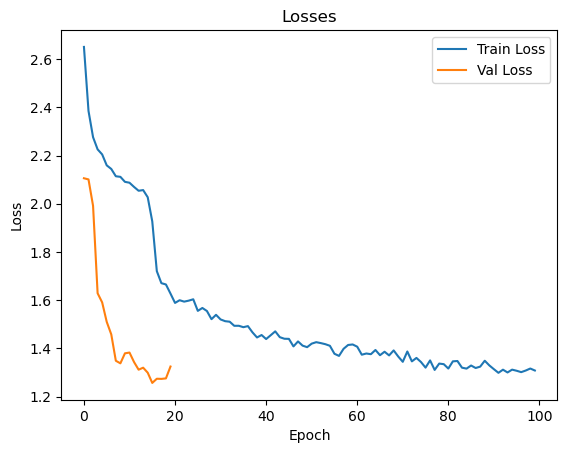

In [133]:
plot_loss(train_losses=train_losses, val_losses=val_losses)

In [ ]:
## Evaluation metrics

_, eval_metrics = evaluate_model(
    model, data_module.val_dataloader(), criterion=criterion
)

print(eval_metrics)